In [ ]:
# check which gpu we're using
!nvidia-smi

In [ ]:
!pip install transformers
!pip install pandas

!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [1]:
import torch

if not torch.cuda.is_available():
    print('WARNING: You may want to change the runtime to GPU for faster training!')
    DEVICE = 'cpu'
else:
    print("CUDA is available")
    DEVICE = 'cuda:0'

CUDA is available


## Load training data

In [2]:
import pandas as pd
from dont_patronize_me import DontPatronizeMe
dpm = DontPatronizeMe('./data', './data/TEST/task4_test.tsv')
dpm.load_task1()

In [3]:
dpm.train_task1_df

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4


## Split into train and dev sets

In [4]:
# get training set and dev set ids
practice_splits_dir = './data/practice_splits/'
train_ids = pd.read_csv(practice_splits_dir + 'train_semeval_parids-labels.csv')
dev_ids = pd.read_csv(practice_splits_dir + 'dev_semeval_parids-labels.csv')

# convert ids to strings
train_ids.par_id = train_ids.par_id.astype(str)
dev_ids.par_id = dev_ids.par_id.astype(str)
train_ids.head()

,par_id,label
0,4341,"[1, 0, 0, 1, 0, 0, 0]"
1,4136,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,"[1, 0, 0, 1, 1, 1, 0]"


In [5]:
def extract_split_data(ids_df, original_df):
    """ ids_df is dataframe with columns 'par_id', 'label'
        original_df is original dataframe with columns 'par_id', 'text', 'label', etc.
    """
    rows = [] # will contain par_id, label and text
    for idx in range(len(ids_df)):  
        par_id = ids_df.par_id[idx]
        # select row from original dataset to retrieve `text` and binary label
        text = original_df.loc[original_df.par_id == par_id].text.values[0]
        label = original_df.loc[original_df.par_id == par_id].label.values[0]
        rows.append({
            'par_id':par_id,
            'text':text,
            'label':label
        })
    return pd.DataFrame(rows)

In [6]:
train_set = extract_split_data(train_ids, dpm.train_task1_df)
train_set

,par_id,text,label
0,4341,"The scheme saw an estimated 150,000 children f...",1
1,4136,Durban 's homeless communities reconciliation ...,1
2,10352,The next immediate problem that cropped up was...,1
3,8279,Far more important than the implications for t...,1
4,1164,To strengthen child-sensitive social protectio...,1
...,...,...,...
8370,8380,Rescue teams search for survivors on the rubbl...,0
8371,8381,The launch of ' Happy Birthday ' took place la...,0
8372,8382,"The unrest has left at least 20,000 people dea...",0
8373,8383,You have to see it from my perspective . I may...,0


In [7]:
dev_set = extract_split_data(dev_ids, dpm.train_task1_df)
dev_set_short = extract_split_data(dev_ids[150:250].reset_index(drop=True), dpm.train_task1_df)
dev_set

,par_id,text,label
0,4046,We also know that they can benefit by receivin...,1
1,1279,Pope Francis washed and kissed the feet of Mus...,1
2,8330,Many refugees do n't want to be resettled anyw...,1
3,4063,"""Budding chefs , like """" Fred """" , """" Winston ...",1
4,4089,"""In a 90-degree view of his constituency , one...",1
...,...,...,...
2089,10462,"The sad spectacle , which occurred on Saturday...",0
2090,10463,""""""" The Pakistani police came to our house and...",0
2091,10464,"""When Marie O'Donoghue went looking for a spec...",0
2092,10465,"""Sri Lankan norms and culture inhibit women fr...",0


## Define downsampling/upsampling functions

In [8]:
def downsample(train_set, ratio=2):
    """ Downsample (majority) negative instances, so num_negative is ratio * num_positive
        args:
            ratio: The ratio of negative (majority) samples compared to positive (minority) samples
    """
    
    pos_samples = train_set[train_set.label==1]
    neg_samples = train_set[train_set.label==0]

    print("Number of positive samples:", len(pos_samples))
    print("Number of negative samples:", len(neg_samples))

    res = pd.concat([pos_samples, neg_samples[:len(pos_samples)*ratio]])

    print("Number of negative samples after downsampling:", len(res[res.label==0]))

    return res

def upsample(train_set, ratio=2):
    """ Upsample (minority) positive instances, so num_negative is ratio * num_positive
        args:
            ratio: The ratio of negative (majority) samples compared to positive (minority) samples
    """
    
    pos_samples = train_set[train_set.label==1]
    neg_samples = train_set[train_set.label==0]

    print("Number of positive samples:", len(pos_samples))
    print("Number of negative samples:", len(neg_samples))

    res = pd.concat([pos_samples.sample(len(neg_samples)//ratio, replace=True), neg_samples])
    res = res.reset_index(drop=True)

    print("Number of positive samples after upsampling:", len(res[res.label==1]))

    return res

## Define Custom Dataset Class

In [9]:
from torch.utils.data import Dataset

class PatroniseDataset(Dataset):
    def __init__(self, tokenizer, input_set):
        self.tokenizer = tokenizer
        self.texts = input_set['text']
        self.labels = input_set['label']
        
    def collate_fn(self, batch):
        texts = []
        labels = []

        for b in batch:
            texts.append(b['text'])
            labels.append(b['label'])

        # The maximum sequence size for BERT is 512 but here the tokenizer truncate sentences longer than 128 tokens.  
        # We also pad shorter sentences to a length of 128 tokens
        encodings = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
        encodings['labels'] =  torch.tensor(labels, dtype=torch.int64)
        
        return encodings
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError
        item = {'text': self.texts[idx],
                'label': self.labels[idx]}
        return item

----------------------------------------------------------------------

Models:
- BERT
- RoBERTa
- XLNet
- DeBERTa

For each, change:
- learning_rate
- batch_size
- num_epochs
- downsampling/upsampling
- loss weighting of pos/neg samples

## AUTO

### Imports

In [10]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

### Define Evaluation functions

In [11]:
def predict_patronise(inputs, tokenizer, model): 
    model.eval()
    encodings = tokenizer(inputs, return_tensors='pt', padding=True, truncation=True, max_length=128)
    encodings.to(DEVICE)
    output = model(**encodings)
    preds = torch.argmax(output.logits, axis=-1)
    return preds

In [12]:
def evaluate(model, tokenizer, data_loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in tqdm(data_loader):
            labels = data['label']
            texts = data['text']
            pred = predict_patronise(texts, tokenizer, model)
            all_preds += pred.tolist()
            all_labels += labels.tolist()

    # with the saved predictions and labels we can compute accuracy, precision, recall and f1-score
    report = classification_report(all_labels, all_preds, target_names=["Not patronising", "Patronising"], output_dict=True)

    return report

In [13]:
def display_report(report):
    print("Not patronising:")
    for k, v in report['Not patronising'].items():
        print(f"{k:<10}: {v}")

    print("\nPatronising:")
    for k, v in report['Patronising'].items():
        print(f"{k:<10}: {v}")

    print("\nAccuracy:", report['accuracy'])
    print("\nThe f1-score we care about:", report['Patronising']['f1-score'])

### Define overall pipeline

In [14]:
from os.path import exists
results_filename = "./results"

def load_results():
    if not exists(results_filename):
        return pd.DataFrame()
    results = pd.read_csv(results_filename)
    results['learning_rate'] = results['learning_rate'].astype(float)
    results['batch_size'] = results['batch_size'].astype(int)
    results['num_epochs'] = results['num_epochs'].astype(int)
    results['sampling'] = results['sampling'].astype(int)
    results['sampling_ratio'] = results['sampling_ratio'].astype(int)
    return results


def save_results(results):
    results.to_csv(results_filename, index=False)

In [15]:
import numpy as np

def get_folds(train_set, n=5):
    np.random.seed(0)
    perm = np.random.permutation(len(train_set))
    indexes = np.arange(len(train_set))
    indexes = indexes[perm]
    folds = np.array_split(indexes, n)
    return folds

In [16]:
def main_patronise_cross_val(pretrained_model_name='bert-base-cased', learning_rate=0.0001, batch_size=32, num_epochs=3, sampling=1, sampling_ratio=2):
    """
    Args:
        pretrained_model_name
        learning_rate
        batch_size
        num_epochs
        sampling: (0 = use original data) (1 = downsample majority class) (2 = upsample minority class)
        sampling_ratio: the ratio of negative (majority) samples compared to positive (minority) samples
    """
    
    # create tokenizer for specified pretrained model
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
    
    # upsample / downsample
    train_set_sampled = downsample(train_set) if sampling == 1 else upsample(train_set) if sampling == 2 else train_set
    
    folds = get_folds(train_set_sampled, n=5)
    reports = []
    for fold in folds:
        # split into train and val for this fold
        val_indexes = fold
        train_indexes = list(set(range(train_set_sampled.shape[0])) - set(val_indexes))
        val_set_i = train_set_sampled.iloc[val_indexes].reset_index()
        train_set_i = train_set_sampled.iloc[train_indexes].reset_index()
        
        # create dataset
        train_dataset = PatroniseDataset(tokenizer, train_set_i)

        # create classification model with specified pretrained model
        model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=2)

        # train model
        training_args = TrainingArguments(
            output_dir = './experiment/patronise',
            learning_rate = learning_rate,
            logging_steps = 100,
            per_device_train_batch_size = batch_size,
            num_train_epochs = num_epochs,
        )
        trainer = Trainer(
            model = model,                         
            args = training_args,                 
            train_dataset = train_dataset,                   
            data_collator = train_dataset.collate_fn
        )
        trainer.train()

        # evaluate model on this fold's val set
        val_dataset = PatroniseDataset(tokenizer, val_set_i)
        val_loader = DataLoader(val_dataset, batch_size=8)
        report = evaluate(model, tokenizer, val_loader)
        reports.append(report)
    
    avg_report = {}
    for lbl in ['Not patronising', 'Patronising']:
        avg_report[lbl] = {}
        for k in reports[0][lbl].keys():
            avg_report[lbl][k] = sum([report[lbl][k] for report in reports]) / len(folds)
    avg_report['accuracy'] = sum([report['accuracy'] for report in reports]) / len(folds)
    
    return avg_report

### Base-model-choosing and Hyperparameter tuning

In [19]:
model_names = ['bert-base-cased', 'roberta-base', 'microsoft/deberta-base'] 
learning_rates = [0.00005, 0.0001, 0.0002, 0.0005, 0.001]
batch_sizes = [16, 32, 64]
num_epochses = [1, 2, 3, 4, 5]
samplings = [(0,0), (1, 2), (2,2)] # [(fst,snd)] where fst is no sampling (0), downsampling (1) or upsampling (2); snd is sampling ratio 

# load results from previous experiments
reports = load_results()

for learning_rate in learning_rates:
    for pretrained_model_name in model_names:
        for batch_size in batch_sizes:
            for num_epochs in num_epochses:
                for (sampling, sampling_ratio) in samplings:
                    
                    torch.cuda.empty_cache()
                    
                    # if this configuration has already been done, skip it
                    already_exists = not reports.empty and not reports.loc[(reports['pretrained_model_name']==pretrained_model_name) &
                                                                   (reports['learning_rate']==learning_rate) &
                                                                   (reports['batch_size']==batch_size) &
                                                                   (reports['num_epochs']==num_epochs) &
                                                                   (reports['sampling']==sampling) &
                                                                   (reports['sampling_ratio']==sampling_ratio)].empty
                    if already_exists:
                        continue
                        
                    print(learning_rate, pretrained_model_name, batch_size, num_epochs, sampling, sampling_ratio)
                        
                    # perform cross validation with this base model and hyperparameter configuration
                    report = main_patronise_cross_val(pretrained_model_name=pretrained_model_name,
                                            learning_rate=learning_rate,
                                            batch_size=batch_size,
                                            num_epochs=num_epochs,
                                            sampling=sampling,
                                            sampling_ratio=sampling_ratio)
                    
                    # add configuration and metrics to results dataframe; save results
                    row = {'pretrained_model_name': pretrained_model_name,
                           'learning_rate': learning_rate,
                           'batch_size': batch_size,
                           'num_epochs': num_epochs,
                           'sampling': sampling,
                           'sampling_ratio': sampling_ratio}
                    print(row)
                    display_report(report)
                    for k, v in report['Not patronising'].items():
                        row[f"neg_{k}"] = v
                    for k, v in report['Patronising'].items():
                        row[f"pos_{k}"] = v
                    row['accuracy'] = report['accuracy']
                    reports = reports.append(row, ignore_index=True)
                    save_results(reports)

In [17]:
reports = load_results()
reports

,pretrained_model_name,learning_rate,batch_size,num_epochs,sampling,sampling_ratio,neg_precision,neg_recall,neg_f1-score,neg_support,pos_precision,pos_recall,pos_f1-score,pos_support,accuracy
0,bert-base-cased,0.00010,32,3,1,2,0.840367,0.868883,0.854024,317.6,0.719911,0.670027,0.692694,158.8,0.802276
1,bert-base-cased,0.00020,32,3,1,2,0.715389,0.920314,0.796504,317.6,0.229385,0.227728,0.227938,158.8,0.686843
2,roberta-base,0.00010,32,3,1,2,0.850487,0.878242,0.863710,317.6,0.740171,0.691064,0.713243,158.8,0.815271
3,bert-base-cased,0.00010,16,1,0,0,0.916840,0.988666,0.951262,1516.2,0.356760,0.142806,0.197611,158.8,0.908299
4,bert-base-cased,0.00010,16,1,1,2,0.827344,0.844663,0.832645,317.6,0.667664,0.629676,0.631929,158.8,0.772444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,bert-base-cased,0.00020,64,3,2,2,0.903291,0.946907,0.918344,1516.2,0.901559,0.740518,0.721444,758.0,0.878986
131,bert-base-cased,0.00020,64,5,2,2,0.786553,0.975751,0.861218,1516.2,0.354115,0.372156,0.362891,758.0,0.775401
132,bert-base-cased,0.00005,64,1,2,2,0.935532,0.938895,0.937175,1516.2,0.878078,0.870664,0.874230,758.0,0.916277
133,bert-base-cased,0.00005,64,3,2,2,0.987825,0.962299,0.974880,1516.2,0.928293,0.976102,0.951546,758.0,0.966934


### Train with best model and optimal hyperparameters

In [18]:
def generate_model_filename(model_name, learning_rate, batch_size, num_epochs, sampling, sampling_ratio):
    sampling_text = f"{'downsampling' if sampling == 1 else 'upsampling'}_{sampling_ratio}" if sampling else ""
    model_filename = f"./models/patronise_{model_name}_{learning_rate}_{batch_size}_{num_epochs}_{sampling_text}/"
    return model_filename

In [19]:
def train_final_model(pretrained_model_name='bert-base-cased', learning_rate=0.0001, batch_size=64, num_epochs=3, sampling=2, sampling_ratio=2, save_model=True):
    """
    Args:
        pretrained_model_name
        learning_rate
        batch_size
        num_epochs
        sampling: (0 = use original data) (1 = downsample majority class) (2 = upsample minority class)
        sampling_ratio: the ratio of negative (majority) samples compared to positive (minority) samples
        save_model: boolean value indicating whether or not to save model parameters/weights
    """
    # Form model filename
    model_filename = generate_model_filename(pretrained_model_name, learning_rate, batch_size, num_epochs, sampling, sampling_ratio)
    
    if exists(model_filename):
        print("Model already exists")
        return model_filename
    
    # create tokenizer for specified pretrained model
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
    
    # upsample / downsample
    train_set_sampled = downsample(train_set) if sampling == 1 else upsample(train_set) if sampling == 2 else train_set
    
    # create dataset
    train_dataset = PatroniseDataset(tokenizer, train_set_sampled)
    
    # create classification model with specified pretrained model
    model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=2)
    
    # train model
    training_args = TrainingArguments(
        output_dir = './experiment/patronise',
        learning_rate = learning_rate,
        logging_steps = 100,
        per_device_train_batch_size = batch_size,
        num_train_epochs = num_epochs,
    )
    trainer = Trainer(
        model = model,                         
        args = training_args,                 
        train_dataset = train_dataset,                   
        data_collator = train_dataset.collate_fn
    )
    trainer.train()
    
    trainer.save_model(model_filename)
    return model_filename

In [20]:
# Get optimal hyperparameters
reports = load_results()
optimal_hyperparams = reports.iloc[[reports['pos_f1-score'].idxmax()]]

print("Best base model:", optimal_hyperparams['pretrained_model_name'].item())
print("\nOptimal hyperparameters:")
print("learning_rate:", optimal_hyperparams['learning_rate'].item())
print("batch_size:", optimal_hyperparams['batch_size'].item())
print("num_epochs:", optimal_hyperparams['num_epochs'].item())
print("sampling:", optimal_hyperparams['sampling'].item())
print("sampling_ratio:", optimal_hyperparams['sampling_ratio'].item())

Best base model: bert-base-cased

Optimal hyperparameters:
learning_rate: 0.0001
batch_size: 64
num_epochs: 3
sampling: 2
sampling_ratio: 2


In [21]:
# Train final model
final_model_filename = train_final_model(pretrained_model_name=optimal_hyperparams['pretrained_model_name'].values[0],
                                         learning_rate=optimal_hyperparams['learning_rate'].item(),
                                         batch_size=optimal_hyperparams['batch_size'].item(),
                                         num_epochs=optimal_hyperparams['num_epochs'].item(),
                                         sampling=optimal_hyperparams['sampling'].item(),
                                         sampling_ratio=optimal_hyperparams['sampling_ratio'].item())

final_tokenizer = AutoTokenizer.from_pretrained(optimal_hyperparams['pretrained_model_name'].values[0])
final_model = AutoModelForSequenceClassification.from_pretrained(final_model_filename, num_labels=2)

Model already exists


In [22]:
# Evaluate model on dev set
final_model.to(DEVICE)
dev_dataset = PatroniseDataset(final_tokenizer, dev_set)
dev_loader = DataLoader(dev_dataset, batch_size=8)
dev_report = evaluate(final_model, final_tokenizer, dev_loader)

display_report(dev_report)

100%|██████████| 262/262 [00:08<00:00, 29.71it/s]

Not patronising:
precision : 0.9399491094147583
recall    : 0.97467018469657
f1-score  : 0.9569948186528499
support   : 1895

Patronising:
precision : 0.627906976744186
recall    : 0.40703517587939697
f1-score  : 0.49390243902439024
support   : 199

Accuracy: 0.9207258834765998

The f1-score we care about: 0.49390243902439024


### Predict on held out test set

In [23]:
# Load test set
dpm.load_test()
dpm.test_set_df

# Drop unneeded columns
dpm.test_set_df.drop(columns=['art_id', 'keyword', 'country'], inplace=True)
dpm.test_set_df

,par_id,text
0,t_0,"In the meantime , conservatives are working to..."
1,t_1,In most poor households with no education chil...
2,t_2,The real question is not whether immigration i...
3,t_3,"In total , the country 's immigrant population..."
4,t_4,"Members of the church , which is part of Ken C..."
...,...,...
3827,t_3893,In a letter dated Thursday to European Commiss...
3828,t_3894,They discovered that poor families with health...
3829,t_3895,"She married at 19 , to Milan ( Emil ) Badovina..."
3830,t_3896,The United Kingdom is n't going to devolve int...


In [24]:
# Helper function to save predictions to an output file
def save_predictions_to_file(preds, filename):
    with open(filename,'w') as f:
        for pred in preds:
            f.write(str(pred.item())+'\n')

In [25]:
# Predict on test set
test_preds = []
test_batch_size = 32
with torch.no_grad():
    for i in tqdm(range(0, len(dpm.test_set_df), test_batch_size)):
        final_model.eval()
        encodings = final_tokenizer([str(x) for x in dpm.test_set_df['text'][i:i+test_batch_size]], return_tensors='pt', padding=True, truncation=True, max_length=128)
        encodings.to(DEVICE)
        output = final_model(**encodings)
        test_preds += torch.argmax(output.logits, axis=-1)

test_preds_filename = 'final_model_test_preds.txt'
save_predictions_to_file(test_preds, test_preds_filename)
print("Test predictions saved to file:", test_preds_filename)

100%|██████████| 120/120 [00:13<00:00,  8.68it/s]


Test predictions saved to file: final_model_test_preds.txt


/tmp/ipykernel_1105/2405344237.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  asd = reports[reports['learning_rate']==optimal_hyperparams['learning_rate'].item()] \


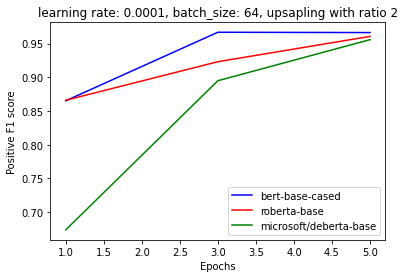

/tmp/ipykernel_1105/2405344237.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  asd = reports[reports['learning_rate']==optimal_hyperparams['learning_rate'].item()] \


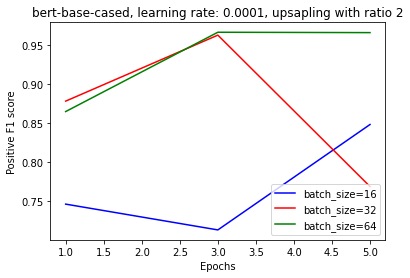

/tmp/ipykernel_1105/2405344237.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  asd = reports[reports['learning_rate']==optimal_hyperparams['learning_rate'].item()] \


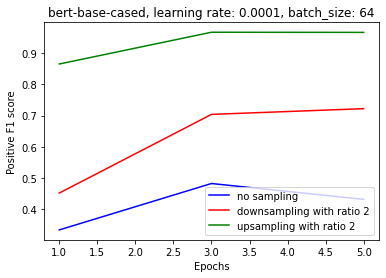

/tmp/ipykernel_1105/2405344237.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  asd = reports[reports['batch_size']==optimal_hyperparams['batch_size'].item()] \


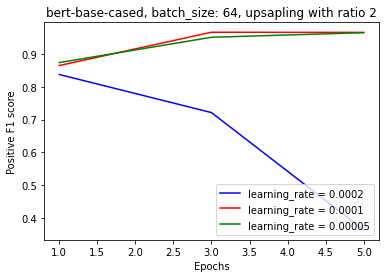

In [27]:
import matplotlib.pyplot as plt

epoch_options = [1, 3, 5]

plt.ylabel('Positive F1 score')
plt.xlabel('Epochs')
plt.title(f"learning rate: {optimal_hyperparams['learning_rate'].item()}, batch_size: {optimal_hyperparams['batch_size'].item()}, upsapling with ratio {optimal_hyperparams['sampling_ratio'].item()}")
asd = reports[reports['learning_rate']==optimal_hyperparams['learning_rate'].item()] \
             [reports['batch_size']==optimal_hyperparams['batch_size'].item()] \
             [reports['sampling']==optimal_hyperparams['sampling'].item()] \
             [reports['sampling_ratio']==optimal_hyperparams['sampling_ratio'].item()] \
             ['pos_f1-score']
asd1 = list(asd[reports['pretrained_model_name']=='bert-base-cased'])
asd2 = list(asd[reports['pretrained_model_name']=='roberta-base'])
asd3 = list(asd[reports['pretrained_model_name']=='microsoft/deberta-base'])
plt.plot(epoch_options, asd1, 'b', label='bert-base-cased')
plt.plot(epoch_options, asd2, 'r', label='roberta-base')
plt.plot(epoch_options, asd3, 'g', label='microsoft/deberta-base')
plt.legend(loc='lower right')
plt.show()

plt.ylabel('Positive F1 score')
plt.xlabel('Epochs')
plt.title(f"{optimal_hyperparams['pretrained_model_name'].item()}, learning rate: {optimal_hyperparams['learning_rate'].item()}, upsapling with ratio {optimal_hyperparams['sampling_ratio'].item()}")
asd = reports[reports['learning_rate']==optimal_hyperparams['learning_rate'].item()] \
             [reports['pretrained_model_name']==optimal_hyperparams['pretrained_model_name'].item()] \
             [reports['sampling']==optimal_hyperparams['sampling'].item()] \
             [reports['sampling_ratio']==optimal_hyperparams['sampling_ratio'].item()] \
             ['pos_f1-score']
asd1 = list(asd[reports['batch_size']==16])
asd2 = list(asd[reports['batch_size']==32])
asd3 = list(asd[reports['batch_size']==64])
plt.plot(epoch_options, asd1, 'b', label='batch_size=16')
plt.plot(epoch_options, asd2, 'r', label='batch_size=32')
plt.plot(epoch_options, asd3, 'g', label='batch_size=64')
plt.legend(loc='lower right')
plt.show()

plt.ylabel('Positive F1 score')
plt.xlabel('Epochs')
plt.title(f"{optimal_hyperparams['pretrained_model_name'].item()}, learning rate: {optimal_hyperparams['learning_rate'].item()}, batch_size: {optimal_hyperparams['batch_size'].item()}")
asd = reports[reports['learning_rate']==optimal_hyperparams['learning_rate'].item()] \
             [reports['batch_size']==optimal_hyperparams['batch_size'].item()] \
             [reports['pretrained_model_name']==optimal_hyperparams['pretrained_model_name'].item()] \
             ['pos_f1-score']
asd1 = list(asd[reports['sampling']==0])
asd2 = list(asd[reports['sampling']==1])
asd3 = list(asd[reports['sampling']==2])
plt.plot(epoch_options, asd1, 'b', label='no sampling')
plt.plot(epoch_options, asd2, 'r', label='downsampling with ratio 2')
plt.plot(epoch_options, asd3, 'g', label='upsampling with ratio 2')
plt.legend(loc='lower right')
plt.show()

plt.ylabel('Positive F1 score')
plt.xlabel('Epochs')
plt.title(f"{optimal_hyperparams['pretrained_model_name'].item()}, batch_size: {optimal_hyperparams['batch_size'].item()}, upsapling with ratio {optimal_hyperparams['sampling_ratio'].item()}")
asd = reports[reports['batch_size']==optimal_hyperparams['batch_size'].item()] \
             [reports['pretrained_model_name']==optimal_hyperparams['pretrained_model_name'].item()] \
             [reports['sampling']==optimal_hyperparams['sampling'].item()] \
             [reports['sampling_ratio']==optimal_hyperparams['sampling_ratio'].item()] \
             ['pos_f1-score']
asd1 = list(asd[reports['learning_rate']==0.0002])
asd2 = list(asd[reports['learning_rate']==0.0001])
asd3 = list(asd[reports['learning_rate']==0.00005])
plt.plot(epoch_options, asd1, 'b', label='learning_rate = 0.0002')
plt.plot(epoch_options, asd2, 'r', label='learning_rate = 0.0001')
plt.plot(epoch_options, asd3, 'g', label='learning_rate = 0.00005')
plt.legend(loc='lower right')
plt.show()